In [1]:
import pandas as pd
import torch
import sklearn as sl
import numpy as np
from torch import nn
import sys
sys.path.append(r'C:\Users\Luke\MyRepo\ReviewGPT')
import functions
from sklearn.metrics import roc_auc_score

## Data Download

In [2]:
from adv_functions import downloadData

path_train = r"C:\Users\Luke\MyRepo\Kaggle\Competition_2\Data\train.csv"
path_test = r"C:\Users\Luke\MyRepo\Kaggle\Competition_2\Data\test.csv"

train = downloadData(path_train)
test = downloadData(path_test)

#Set up response and training data
response = pd.get_dummies(train['defects'], prefix = 'defects')


In [3]:
train.head(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
response.head(5)

,defects_False,defects_True
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0


In [5]:
test.head(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,101766,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,101767,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


**Data Transform**

In [6]:
from adv_functions import transformData

transformed_data = transformData(train)
predictor_var = transformed_data
predictor_var.drop('defects', axis=1, inplace=True)
test_transfromed = transformData(test)

In [7]:
transformed_data.head(5)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,-0.281081,-0.315495,-0.398384,-0.270813,-0.214178,-0.204322,-0.515840,0.416259,-0.582892,-0.080835,...,-0.085031,-0.150553,-0.131124,-0.466891,-0.196819,0.608021,-0.365178,-0.187761,-0.240607,-0.335782
1,-0.427601,-0.442064,-0.398384,-0.270813,-0.377780,-0.304543,0.283393,-0.473177,-0.282762,-0.104511,...,-0.110447,-0.306231,-0.300546,-0.466891,-0.196819,-0.132769,-0.254462,-0.379080,-0.352195,-0.474548
2,-0.482545,-0.442064,-0.398384,-0.270813,-0.301822,-0.268046,-0.016319,-0.398822,-0.210573,-0.100223,...,-0.105843,-0.384070,-0.300546,-0.466891,-0.196819,0.015389,-0.254462,-0.283421,-0.310350,-0.474548
3,-0.537490,-0.568633,-0.398384,-0.451496,-0.430366,-0.349602,0.782914,-0.597104,-0.424952,-0.106941,...,-0.113056,-0.487856,-0.300546,-0.310209,-0.196819,-0.577243,-0.531252,-0.398212,-0.449835,-0.613314
4,-0.482545,-0.442064,-0.398384,-0.270813,-0.465424,-0.375625,0.683010,-0.570194,-0.662081,-0.107508,...,-0.113664,-0.410017,-0.300546,-0.310209,-0.196819,-0.725401,-0.531252,-0.455607,-0.407989,-0.474548


## Modelling

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

test_transfromed_t = torch.tensor(test_transfromed.values, dtype = torch.float32).to(device)

In [9]:
from adv_functions import ScoreNeuralNetwork
from sklearn.model_selection import train_test_split
from adv_functions import  classificationWeightByClass

#Create test and train datasets
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(predictor_var, response, test_size=0.1, random_state=42, stratify=response)

#We need to first rebalance the transformed dataset.
weights = classificationWeightByClass("defects_True", response, device = device)

#Create tensors
response_var_binary_t = torch.tensor(Y_train_binary.values, dtype = torch.float).to(device)
response_var_binary_t = torch.squeeze(response_var_binary_t, 1)
predictor_var_t = torch.tensor(X_train_binary.values, dtype = torch.float).to(device)

#Create model
n_columns = len(transformed_data.columns)

nn = ScoreNeuralNetwork(n_input = n_columns, n_hidden_layer = n_columns, n_output = 2, learning_rate = 0.01, weights = weights).to(device)
print(nn)

ScoreNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=21, bias=True)
    (1): ReLU()
    (2): Linear(in_features=21, out_features=21, bias=True)
    (3): ReLU()
    (4): Linear(in_features=21, out_features=21, bias=True)
    (5): ReLU()
    (6): Linear(in_features=21, out_features=21, bias=True)
    (7): ReLU()
    (8): Linear(in_features=21, out_features=21, bias=True)
    (9): ReLU()
    (10): Linear(in_features=21, out_features=2, bias=True)
    (11): Sigmoid()
  )
  (loss_function): CrossEntropyLoss()
)


250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3142380714416504, curr auc: 0.59
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3141863942146301, curr auc: 0.60
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3141340911388397, curr auc: 0.61
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3140805959701538, curr auc: 0.63
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.31402507424354553, curr auc: 0.64
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3139668107032776, curr auc: 0.65
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3139050304889679, curr auc: 0.66
250 iterations complete, current test accuracy: 0.77, curr entropy: 0.3138386011123657, curr auc: 0.67
250 iterations complete, current test accuracy: 0.78, curr entropy: 0.3137664794921875, curr auc: 0.68
250 iterations complete, current test accuracy: 0.78, curr entropy: 0.31

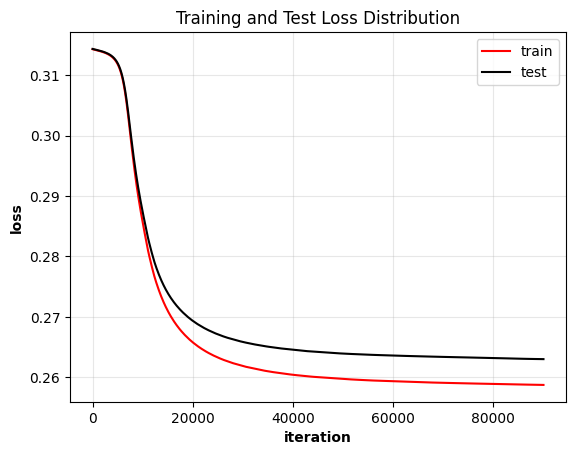

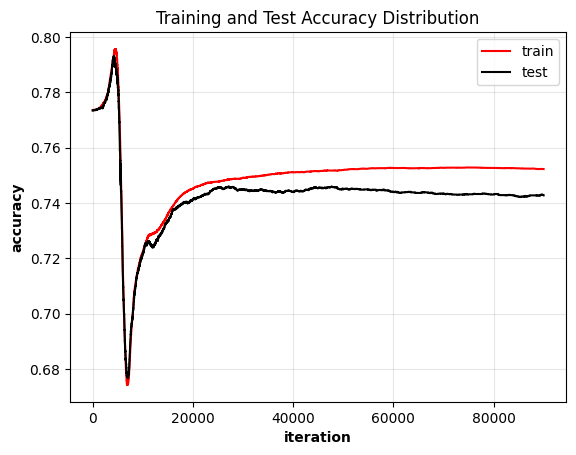

best accuracy achieved at iteration 89988 with accuracy 0.79


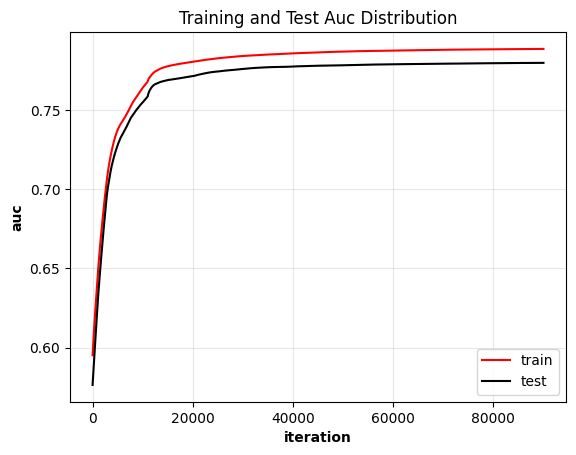

best auc achieved at iteration 89988 with auc 0.78


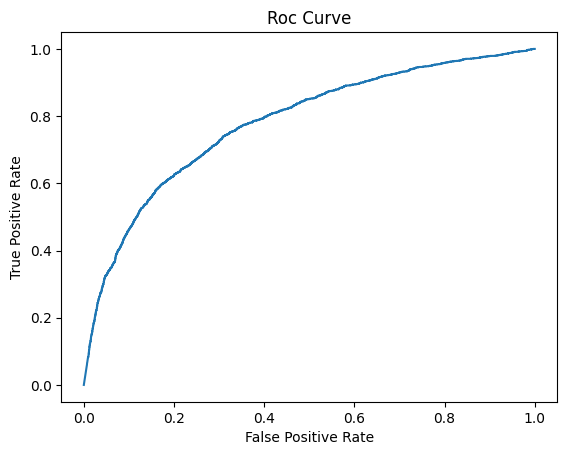

In [10]:
#Convert test data to tensors
Y_test_t = torch.tensor(Y_test_binary.values, dtype = torch.float).to(device)
Y_test_t = torch.squeeze(Y_test_t, 1)
X_test_t = torch.tensor(X_test_binary.values, dtype = torch.float).to(device)

nn.train(x_train = predictor_var_t, y_train = response_var_binary_t, x_test = X_test_t, y_test = Y_test_t, batch_size=90000)

## Model Diagnostics ##

In [11]:
from utils import accuracy
from adv_functions import inverseDummies

X_test_t = torch.tensor(X_test_binary.values, dtype = torch.float32).to(device)

predictions_prob = nn.model(X_test_t).detach().cpu().numpy()
#Turn probability into prediction
max_indices = np.argmax(predictions_prob, axis=1)

#Y_test_unenc = ordinalEncoder(Y_test, inverse = True)
Y_test_unec = inverseDummies(Y_test_binary)

auc = roc_auc_score(Y_test_unec, predictions_prob[:,1])

print(f'Auc score: {auc}')
accuracy(Y_test_unec, max_indices)

Auc score: 0.7800018891732746
Accuracy: 0.742753267171072
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      7870
           1       0.45      0.65      0.53      2307

    accuracy                           0.74     10177
   macro avg       0.67      0.71      0.68     10177
weighted avg       0.79      0.74      0.76     10177



In [46]:
predictions_test = nn.model(test_transfromed_t).detach().cpu().numpy()
predictions_for_export = pd.DataFrame(predictions_test)
predictions_for_export = pd.concat([predictions_for_export, test['id']], axis=1)
predictions_for_export['defects'] = predictions_for_export[1]


In [47]:
#Save the predictions
path = r'C:/Users/Luke/MyRepo/Kaggle/Competition_2/Predictions/predictions.csv'
predictions_for_export.to_csv(path, columns= ['id', 'defects'], index=False)

Confusion Matrix:

False Positives: 1812
False Negatives: 806
True Positives: 1501
True Negatives: 6058


AttributeError: module 'matplotlib' has no attribute 'show'

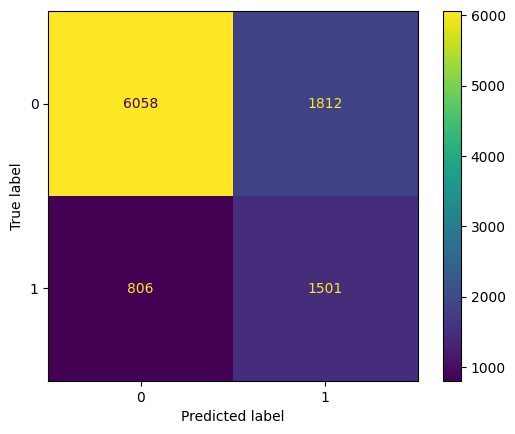

In [14]:
from utils import confusionMatrix

Y_test_binary_cc = pd.DataFrame(Y_test_binary)
Y_test_binary_cc = Y_test_binary_cc['defects_True']

confusionMatrix(Y_test_binary_cc, max_indices)

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_classifier = XGBClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [800, 1600, 2400, 3000],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=2, scoring='roc_auc', n_jobs = -1)

grid_search.fit(X_train_binary, Y_train_binary)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

C:\Users\Luke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}


In [34]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight


model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', n_estimators = 800, learning_rate = 0.01, max_depth = 5)

#Dataset is unbalnced so we need to adjust weights in sample_weight to account for probabibalistic bias to positive.
weights_class = class_weight.compute_class_weight(class_weight = 'balanced', classes = [0,1], y = Y_train_binary['defects_True'])
#Assigns weights to each sample observation.
weights = Y_train_binary.apply(lambda row: weights_class[row])['defects_True']

model.fit(X_train_binary, Y_train_binary['defects_True'], sample_weight=weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
from utils import accuracy
from adv_functions import inverseDummies


predictions = model.predict_proba(X_test_binary)
predictions_gbm = predictions[:,1]
#Turn probability into prediction
predictions_gbm = np.where(predictions_gbm > 0.5, 1, 0)

auc = roc_auc_score(Y_test_binary['defects_True'], predictions_gbm)

print(f'Auc score: {auc}')
accuracy(Y_test_binary['defects_True'], predictions_gbm)

Auc score: 0.7142970209995655
Accuracy: 0.7493367397071828
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      7870
           1       0.46      0.65      0.54      2307

    accuracy                           0.75     10177
   macro avg       0.67      0.71      0.68     10177
weighted avg       0.79      0.75      0.76     10177



## Random Forest Clasifier ##

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

xgb_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [1100, 1400, 1700, 2000],
    'max_depth': [5, 7, 9, 11],
    'min_impurity_decrease' : [0.001, 0.005, 0.01, 0.015]

}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=2, scoring='roc_auc', n_jobs = -1)

grid_search.fit(X_train_binary, Y_train_binary)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 9, 'min_impurity_decrease': 0.001, 'n_estimators': 2000}


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

forest = RandomForestClassifier(criterion = 'gini', n_estimators = 1700, max_depth = 9)

#Dataset is unbalnced so we need to adjust weights in sample_weight to account for probabibalistic bias to positive.
weights_class = class_weight.compute_class_weight(class_weight = 'balanced', classes = [0,1], y = Y_train_binary['defects_True'])
#Assigns weights to each sample observation.
weights = Y_train_binary.apply(lambda row: weights_class[row])['defects_True']

forest.fit(X_train_binary, Y_train_binary['defects_True'], sample_weight=weights)

RandomForestClassifier(max_depth=9, n_estimators=1700)

In [45]:
from utils import accuracy

predictions = forest.predict_proba(X_test_binary)
predictions_forest = predictions[:,1]
#Turn probability into prediction
predictions_forest = np.where(predictions_forest > 0.5, 1, 0)

auc = roc_auc_score(Y_test_binary['defects_True'], predictions_forest)

print(f'Auc score: {auc}')
accuracy(Y_test_binary['defects_True'], predictions_forest)

Auc score: 0.7165436225530937
Accuracy: 0.7577871671415938
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      7870
           1       0.47      0.64      0.55      2307

    accuracy                           0.76     10177
   macro avg       0.68      0.72      0.69     10177
weighted avg       0.79      0.76      0.77     10177



In [48]:
predictions_gbm_test = model.predict_proba(test_transfromed)
predictions_for_export_gbm = pd.DataFrame(predictions_gbm_test)
predictions_for_export_gbm = pd.concat([predictions_for_export_gbm, test['id']], axis=1)
predictions_for_export_gbm['defects'] = predictions_for_export_gbm[1]

predictions_forest_test = forest.predict_proba(test_transfromed)
predictions_for_export_forest = pd.DataFrame(predictions_forest_test)
predictions_for_export_forest = pd.concat([predictions_for_export_forest, test['id']], axis=1)
predictions_for_export_forest['defects'] = predictions_for_export_forest[1]



In [ ]:
#Save the predictions
path = r'C:/Users/Luke/MyRepo/Kaggle/Competition_2/Predictions/predictions.csv'
predictions_for_export.to_csv(path, columns= ['id', 'defects'], index=False)

In [57]:
final_predictions_for_export = 0.1*predictions_for_export_forest+0.2*predictions_for_export+0.7*predictions_for_export_gbm
final_predictions = (0.1*predictions_forest+0.4*max_indices+0.3*predictions_gbm).round()
final_predictions_prob = (0.1*predictions_forest+0.8*max_indices+0.1*predictions_gbm)



In [59]:
from utils import accuracy
from adv_functions import weightFinder

weights_class = class_weight.compute_class_weight(class_weight = 'balanced', classes = [0,1], y = Y_test_binary['defects_True'])
#Assigns weights to each sample observation.
weights = Y_test_binary.apply(lambda row: weights_class[row])['defects_True']

model_weights = weightFinder(predictions_forest, max_indices, predictions_gbm, Y_test_binary['defects_True'], weights)

final_predictions_prob = (model_weights[0]*predictions_forest+model_weights[1]*max_indices+model_weights[2]*predictions_gbm)

auc = roc_auc_score(Y_test_binary['defects_True'], final_predictions_prob, sample_weight=weights)

print(f'Auc score: {auc}')
accuracy(Y_test_binary['defects_True'], final_predictions)

TypeError: cannot unpack non-iterable int object

In [ ]:
#Save the predictions
path = r'C:/Users/Luke/MyRepo/Kaggle/Competition_2/Predictions/predictions.csv'
final_predictions_for_export.to_csv(path, columns= ['id', 'defects'], index=False)